# GMRES tolerance study of _P. dumerilii_ model

We simulated a model of a _Platynaereis dumerilii_ larva, represented as a sphere with a single ring of cilia around it. A real _P. dumerilii_ larva has a diameter of approximately $160 \mu\mathrm{m}$ and cilia of approximately $20 \mu\mathrm{m}$ in length, and so we set the ratio between the diameter of the sphere and the cilium length to $8$. The simulations were ran for a total of one period (which all cilia share, thus giving the entirety of the information available) with $500$ timesteps ($\Delta t = 0.002$).

The sphere radius is set to $a = 1$, setting the length scale. All $309$ cilia were discretised with $20$ segments, and the sphere itself was discretised with $9000$ blobs. This discretisation sets the length of a cilium to $49.4$ dimensionless length units, which gives a sphere of $395.2$ units in diameter, stretching from $-197.6$ to $197.6$ in each direction. Its circumference is therefore approximately $1241.5$ units. To maintain at least $2a$ units of separation between cilia, we have an upper limit of $309$ cilia to be seeded. It would be $310$ (since $310\cdot 4 = 1240$), but we set a realistic tilt angle of $12.5$ degrees which demanded more space. Real _P. dumerilii_ have a separation of around $0.4 \mu\mathrm{m}$ between cilia, which corresponds to $0.988$ dimensionless units of length; a little less than half of the smallest we can set.

The hydrodynamics were resolved using FFCM, with the enclosing domain being $\Omega = [-4000, 4000]^3$.

Each simulation sets a metachronal wave around the sphere with a wavenumber of 15. This number $k$ relates to the dimensional wavelength $\lambda$ via
$$
  \lambda = \frac{160\pi \mu\mathrm{m}}{k}
$$
so that the dimensional wavelength is $\lambda \approx 33.5 \mu \mathrm{m}$.

We tried simulating this system with $500$ maximum GMRES iterations, with and without preconditioning, varying the tolerance for convergence.

Let's analyse the data by first obtaining all phases, velocities and forces corresponding to the simulations and organising them by GMRES setting. All the following graphs are in dimensionless units, where the units were set in time to the period, in length to the blob radius and, indirectly, in force to the viscosity.

In [4]:
import os
import glob

def create_wavenumber_dict():
    # Base path for data directory
    base_path = "../../data"
    
    # Dictionary to store wavenumber -> path mappings
    wave_dict = {}
    
    # Common filename pattern
    filename_pattern = "ciliate_309fil_9000blob_8.00R_0.0010torsion_0.2182tilt"
    filename_pattern += "_0.3000f_eff_1.4960theta0_0.0000freqshift_"
    
    # Find all metachronal wave directories
    wave_dirs = glob.glob(os.path.join(base_path, "wave_N15_gmrestol_*"))
    precon_wave_dirs = glob.glob(os.path.join(base_path, "precon_wave_N15_gmrestol_*"))
    
    for wave_dir in wave_dirs:
        # Extract N wavenumber from directory name
        N = int(wave_dir.split('_')[-1])
        
        # Find the date subdirectory (most recent if multiple exist)
        date_dirs = glob.glob(os.path.join(wave_dir, "*"))
        if date_dirs:
            latest_date_dir = max(date_dirs)  # Gets the most recent date
            full_path = os.path.join(latest_date_dir, filename_pattern)
            
            # Convert absolute path to relative path
            rel_path = os.path.relpath(full_path, os.path.dirname(os.getcwd()))
            wave_dict[N] = os.path.join('..', rel_path)
    
    precon_wave_dict = {}
    for wave_dir in precon_wave_dirs:
        # Extract N wavenumber from directory name
        N = int(wave_dir.split('_')[-1])
        
        # Find the date subdirectory (most recent if multiple exist)
        date_dirs = glob.glob(os.path.join(wave_dir, "*"))
        if date_dirs:
            latest_date_dir = max(date_dirs)  # Gets the most recent date
            full_path = os.path.join(latest_date_dir, filename_pattern)
            
            # Convert absolute path to relative path
            rel_path = os.path.relpath(full_path, os.path.dirname(os.getcwd()))
            precon_wave_dict[N] = os.path.join('..', rel_path)
    
    return wave_dict, precon_wave_dict

# Create the dictionaries
wave_dict, precon_wave_dict = create_wavenumber_dict()

In [5]:
import numpy as np

def create_data_dict(wave_dict):
    # Define file suffixes and their keys
    file_mappings = {
        "body_vel": "body_vels.dat",
        "phase": "true_states.dat", 
        "forces": "seg_forces.dat",
        "velocities": "seg_vels.dat",
        "blob_forces": "blob_forces.dat",
        "blob_references": "blob_references.dat",
    }
    
    # Dictionary to store all data
    data_dict = {}
    
    # For each wavenumber
    for k, base_path in wave_dict.items():
        data_dict[k] = {}
        
        # For each data type
        for key, suffix in file_mappings.items():
            full_path = base_path + suffix
            try:
                # Load data from .dat file into numpy array
                data = np.loadtxt(full_path)
                data_dict[k][key] = data
            except FileNotFoundError:
                print(f"Warning: File not found for N={k}, {key}: {full_path}")
                data_dict[k][key] = None
    
    return data_dict

In [6]:
# Create the nested dictionary with data arrays
data_dict = create_data_dict(wave_dict)
precon_data_dict = create_data_dict(precon_wave_dict)

# Example of accessing data:
# data_dict[38]["body_vel"] gives numpy array of body velocities for k=38
# data_dict[1]["phase"] gives numpy array of phase data for k=1

In [7]:
def clean_data(data_dict):
    # For each wavenumber
    for k in data_dict:
        if data_dict[k]["blob_forces"] is not None:
            # Drop first column of indices by selecting from index 1 onwards
            data = data_dict[k]["blob_forces"][:, 1:]

            # Reshape to separate forces for each blob
            # Each row will have 9000 sets of 3 values (force per blob)
            # Reshape to (timesteps, 9000 blobs, 3 components)
            reshaped = data.reshape(data.shape[0], 9000, 3)
            
            # Store the blob forces array
            data_dict[k]["blob_forces"] = reshaped

        if data_dict[k]["blob_references"] is not None:
            # Reshape to separate position of each blob
            # There is only one row of 9000*3 values
            # Reshape to (9000 blobs, 3 components)
            reshaped = data_dict[k]["blob_references"].reshape(9000, 3)
            
            # Store the array
            data_dict[k]["blob_references"] = reshaped

        if data_dict[k]["phase"] is not None:
            # Drop first two columns by selecting from index 2 onwards
            data_dict[k]["phase"] = data_dict[k]["phase"][:, 2:]

        if data_dict[k]["body_vel"] is not None:
            # Extract data array
            data = data_dict[k]["body_vel"]
            
            # Drop first column (index) and split into linear and angular
            # velocities
            linear_vel = data[:, 1:4]    # Columns 1,2,3 for linear velocity
            angular_vel = data[:, 4:7]   # Columns 4,5,6 for angular velocity
            
            # Replace original data with dictionary containing separated
            # components
            data_dict[k]["body_vel"] = {
                "linear": linear_vel,
                "angular": angular_vel
            }
        if data_dict[k]["forces"] is not None:
            # Extract data array and drop first column (index)
            data = data_dict[k]["forces"][:, 1:]
            
            # Reshape to separate forces and torques
            # Each row will have 309*20 sets of 6 values (force + torque per
            # segment) Reshape to (timesteps, 309 cilia, 20 segments,
            # 6 components)
            reshaped = data.reshape(data.shape[0], 309, 20, 6)
            
            # Keep only force vectors (first 3 components)
            forces = reshaped[:, :, :, :3]
            
            # Store the forces array (shape: timesteps, 309 cilia, 20 segments,
            # 3 components)
            data_dict[k]["forces"] = forces

        if data_dict[k]["velocities"] is not None:
            # Extract data array and drop first column (index)
            data = data_dict[k]["velocities"][:, 1:]
            
            # Reshape to separate velocities and angular velocities
            # Each row will have 309*20 sets of 6 values (velocity + angular
            # velocity per segment) Reshape to (timesteps, 309 cilia,
            # 20 segments, 6 components)
            reshaped = data.reshape(data.shape[0], 309, 20, 6)
            
            # Keep only velocity vectors (first 3 components)
            velocities = reshaped[:, :, :, :3]
            
            # Store the velocities array (shape: timesteps, 309 cilia,
            # 20 segments, 3 components)
            data_dict[k]["velocities"] = velocities
    
    return data_dict
    
# Clean the phase data
data_dict_clean = clean_data(data_dict)
precon_data_dict_clean = clean_data(precon_data_dict)

# Now:

# data_dict_clean[k]["phase"] contains only the relevant cilia phase data
# Each row has 309 values, one for each cilium

# data_dict_clean[k]["body_vel"] contains:
# - "linear": numpy array with shape (timesteps, 3) for linear velocity
# components
# - "angular": numpy array with shape (timesteps, 3) for angular velocity
# components

# data_dict_clean[k]["forces"][t, c, s] is the 3-vector containing the force of
# the s-th segment of the c-th cilium at time t

# data_dict_clean[k]["velocities"][t, c, s] is the 3-vector containing the
# velocity of the s-th segment of the c-th cilium at time t

In [8]:
def compute_blob_velocities(data_dict):
    """Compute blob velocities from body motion and reference positions."""
    for k in data_dict:
        if (data_dict[k]["body_vel"] is not None and 
            data_dict[k]["blob_references"] is not None):
            
            # Extract data
            body_vel = data_dict[k]["body_vel"]["linear"]  # (timesteps, 3)
            angular_vel = data_dict[k]["body_vel"]["angular"]  # (timesteps, 3)
            blob_refs = data_dict[k]["blob_references"]  # (9000, 3)
            
            # Initialize array for blob velocities
            # Shape: (timesteps, 9000 blobs, 3 components)
            timesteps = body_vel.shape[0]
            blob_vels = np.zeros((timesteps, 9000, 3))
            
            # For each timestep
            for t in range(timesteps):
                # Broadcast body velocity to all blobs
                blob_vels[t] = body_vel[t]  # Broadcasting adds velocity to all
                # blobs
                
                # Add angular contribution: ω × r
                # Using cross product for each blob
                # The blob reference works because the body is initialised at
                # the origin
                cross_products = np.cross(angular_vel[t], blob_refs)
                blob_vels[t] += cross_products
            
            # Store in data dictionary
            data_dict[k]["blob_velocities"] = blob_vels
    
    return data_dict

data_dict_clean = compute_blob_velocities(data_dict_clean)
precon_data_dict_clean = compute_blob_velocities(precon_data_dict_clean)

# Now data_dict[k]["blob_velocities"][t,b] gives the velocity vector of blob b
# at time t

In [9]:
time = np.linspace(0, 1, data_dict_clean[5]["phase"].shape[0])

We first study the speed of the swimmer in time with decreasing wavelength.

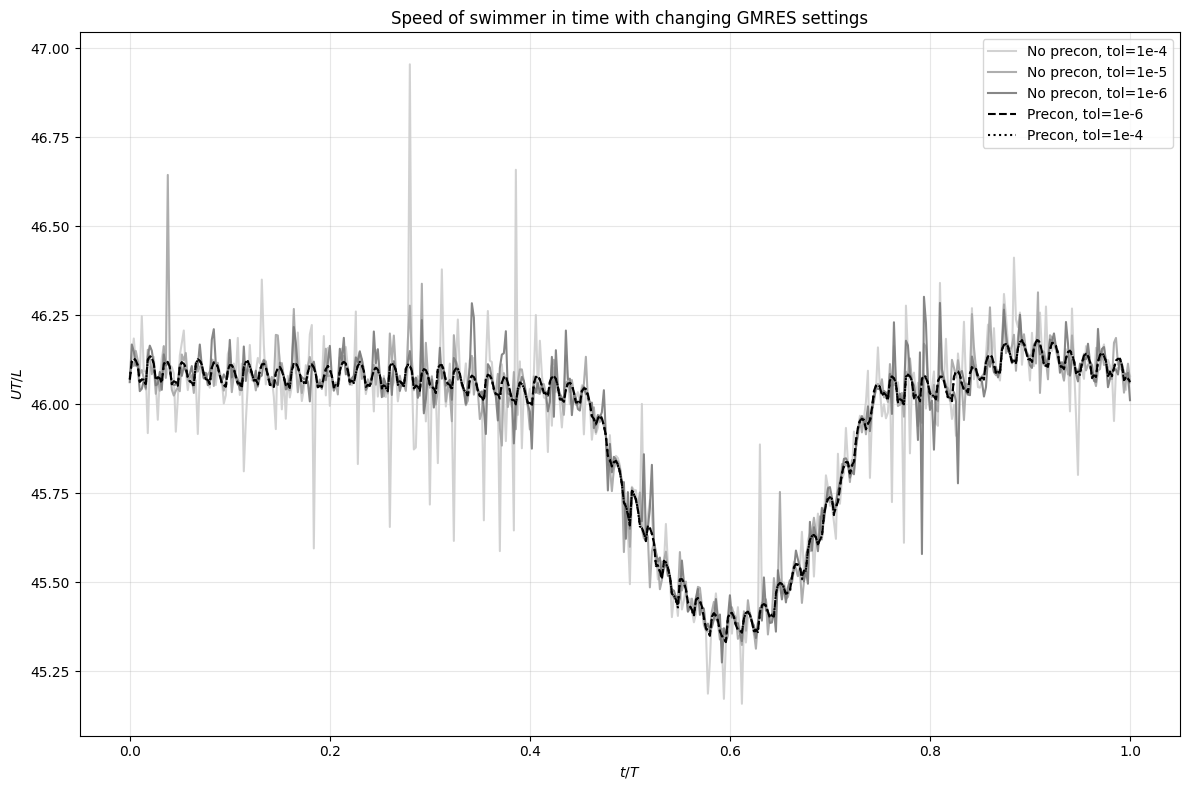

In [24]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

def plot_speed_vs_time_transparent(data_dict, precon_data_dict):
    plt.figure(figsize=(12, 8))
    
    # Use different line styles and transparency
    colors = plt.cm.Greys(np.linspace(0.3, 0.6, len(data_dict)))
    
    for (k, data), color in zip(sorted(data_dict.items(), reverse=False), colors):
        if data["body_vel"] is not None:
            speed = np.linalg.norm(data["body_vel"]["linear"], axis=1)
            plt.plot(time, speed, '-', color=color, alpha=0.9,
                    label=f'No precon, tol=1e-{k}')
    
    linestyles = ['--', '-.', ':']
    
    for (k, data), color, linestyle in zip(sorted(precon_data_dict.items(), reverse=True), colors, linestyles):
        if data["body_vel"] is not None:
            speed = np.linalg.norm(data["body_vel"]["linear"], axis=1)
            plt.plot(time, speed, linestyle=linestyle, color='black', alpha=1,
                     label=f'Precon, tol=1e-{k}')
    
    plt.xlabel(r'$t/T$')
    plt.ylabel(r'$U T/L$')
    plt.title('Speed of swimmer in time with changing GMRES settings')
    plt.grid(True, alpha=0.3)
    
    # Two-column legend
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the speed vs time
plot_speed_vs_time_transparent(data_dict_clean, precon_data_dict_clean)


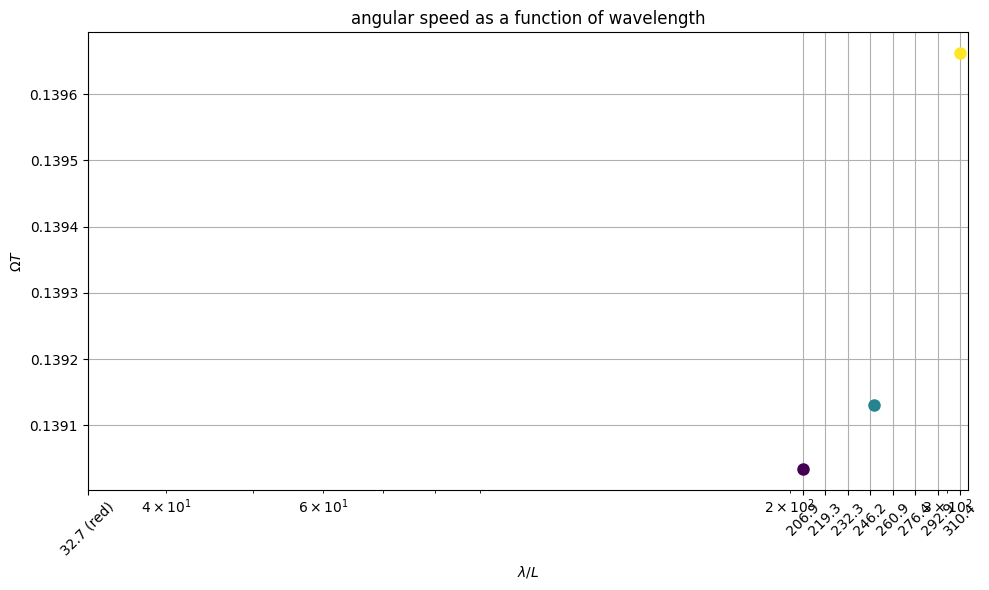

In [11]:
import matplotlib.pyplot as plt

def plot_avg_wobble_vs_wavelength(data_dict):
    avg_speeds = []
    wavelengths = []
    
    for k, data in data_dict.items():
        if data["body_vel"] is not None:
            # Calculate the norm of the angular velocity
            speed = np.linalg.norm(data["body_vel"]["angular"], axis=1)
            avg_speed = np.mean(speed)
            avg_speeds.append(avg_speed)
            wavelength = np.pi * 395.2 / k
            wavelengths.append(wavelength)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Create color mapping
    norm = LogNorm(vmin=min(wavelengths), vmax=max(wavelengths))
    cmap = plt.get_cmap('viridis')
    
    # Plot points with colors based on wavelength
    for wavelength, speed in zip(wavelengths, avg_speeds):
        if np.isclose(wavelength, np.pi * 395.2 / 38, rtol=1e-10):
            plt.plot(wavelength, speed, 'ro', markersize=10)  # Red dot for k=38
        else:
            color = cmap(norm(wavelength))
            plt.plot(wavelength, speed, 'o', color=color, markersize=8)
    
    # Set log scale for x-axis
    plt.xscale('log')
    
    # Create logarithmically spaced ticks
    log_min = np.log(min(wavelengths))
    log_max = np.log(max(wavelengths))
    log_ticks = np.linspace(log_min, log_max, 8)
    new_ticks = np.exp(log_ticks)
    
    # Add k=38 wavelength to ticks
    wavelength_38 = np.pi * 395.2 / 38
    new_ticks = np.sort(np.append(new_ticks, wavelength_38))
    
    # Create labels
    labels = [f'{t:.1f}' + (
        ' (red)' if np.isclose(t, wavelength_38, rtol=1e-10) else ''
    ) for t in new_ticks]
    
    # Set ticks and labels for both plot and colorbar
    plt.xticks(new_ticks, labels, rotation=45)
    
    plt.xlabel(r'$\lambda/L$')
    plt.ylabel(r'$\Omega T$')
    plt.title('angular speed as a function of wavelength')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the average angular speed vs wavelength
plot_avg_wobble_vs_wavelength(data_dict_clean)

It seems that wobbling is minimised with wavelength, but with no apparent saturation. It is interesting that the very next wavelength after the system has higher wobbling: maybe it's a local minima.

Now we look at the average speed and top speed as a function of wavelength.

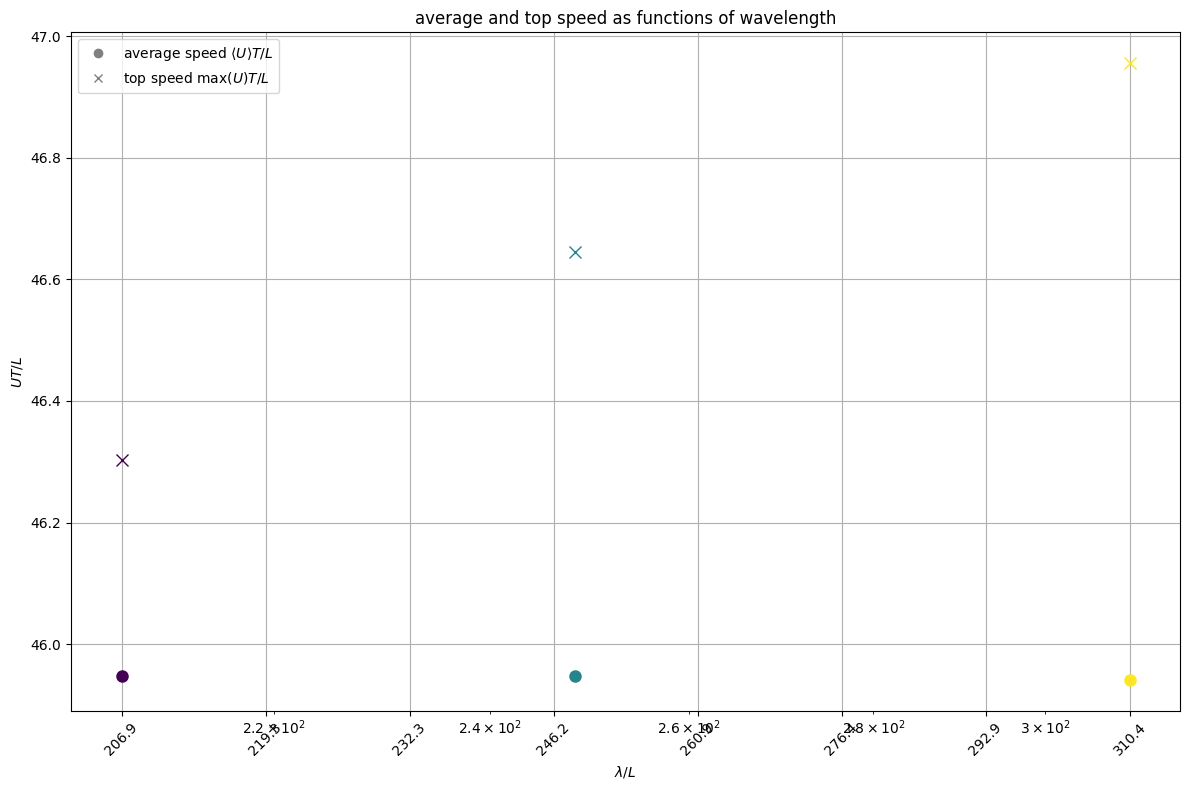

In [12]:
import matplotlib.pyplot as plt

def plot_avg_and_top_speed_vs_wavelength(data_dict):
    avg_speeds = []
    top_speeds = []
    wavelengths = []
    wavenumbers = sorted(data_dict.keys())
    
    for k, data in data_dict.items():
        if data["body_vel"] is not None:
            # Calculate speeds from linear velocity
            speed = np.linalg.norm(data["body_vel"]["linear"], axis=1)
            avg_speed = np.mean(speed)
            top_speed = np.max(speed)
            
            avg_speeds.append(avg_speed)
            top_speeds.append(top_speed)
            wavelength = np.pi * 395.2 / k
            wavelengths.append(wavelength)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Create color mapping
    norm = LogNorm(vmin=min(wavelengths), vmax=max(wavelengths))
    cmap = plt.get_cmap('viridis')
    
    # Plot average and top speeds
    for wavelength, avg_speed, top_speed in zip(
        wavelengths, avg_speeds, top_speeds
    ):
        if np.isclose(wavelength, np.pi * 395.2 / 38, rtol=1e-10):
            plt.plot(wavelength, avg_speed, 'ro', markersize=10)
            plt.plot(wavelength, top_speed, 'rx', markersize=10)
        else:
            color = cmap(norm(wavelength))
            plt.plot(wavelength, avg_speed, 'o', color=color, markersize=8)
            plt.plot(wavelength, top_speed, 'x', color=color, markersize=8)
    
    # Set log scale for x-axis
    plt.xscale('log')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    # cbar = plt.colorbar(sm)
    # cbar.set_label('Wavelength')
    
    # Create logarithmically spaced ticks
    log_min = np.log(min(wavelengths))
    log_max = np.log(max(wavelengths))
    log_ticks = np.linspace(log_min, log_max, 8)
    new_ticks = np.exp(log_ticks)
    
    # Add k=38 wavelength
    wavelength_38 = np.pi * 395.2 / 38
    new_ticks = np.sort(np.append(new_ticks, wavelength_38))
    
    # Create labels
    labels = [f'{t:.1f}' + (
        ' (red)' if np.isclose(t, wavelength_38, rtol=1e-10) else ''
    ) for t in new_ticks]
    
    # Set ticks and labels for both plot and colorbar
    plt.xticks(new_ticks, labels, rotation=45)
    # cbar.set_ticks(new_ticks)
    # cbar.set_ticklabels(labels)
    
    plt.xlabel(r'$\lambda/L$')
    plt.ylabel(r'$UT/L$')
    plt.title('average and top speed as functions of wavelength')
    plt.grid(True)
    
    # Add legend for circle/square markers
    plt.plot([], [], 'o', color='gray', label=r'average speed $\langle U \rangle T/L$')
    plt.plot([], [], 'x', color='gray', label=r'top speed $\max(U) T/L$')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the average and top speed vs wavelength
plot_avg_and_top_speed_vs_wavelength(data_dict_clean)

Here it seems that the real wavelength might be close to a local maxima for both average and top speeds, althout there is a higher value with smaller wavelength.

Then we study the energy dissipation of the swimmer in time with decreasing wavelength, the total energy dissipation as a function of wavelength and the average energy dissipation as a function of wavelength.

In [13]:
def compute_energy_dissipation(data_dict):
    energy_dissipation = {}

    for k, data in data_dict.items():
        if data["forces"] is not None and data["velocities"] is not None:
            # Compute energy dissipation for segments

            # Shape: (timesteps, 309 cilia, 20 segments, 3 components)
            segment_forces = data["forces"]
            # Shape: (timesteps, 309 cilia, 20 segments, 3 components)
            segment_velocities = data["velocities"]
            # Dot product along last axis
            segment_dissipation = np.sum(segment_forces*segment_velocities, axis=-1)
            # Sum over cilia and segments
            total_segment_dissipation = np.sum(segment_dissipation, axis=(1, 2))

        # Compute energy dissipation for blobs if available
        if data["blob_forces"] is not None and data["blob_velocities"] is not None:
            # Shape: (timesteps, 9000 blobs, 3 components)
            blob_forces = data["blob_forces"]
            # Shape: (timesteps, 9000 blobs, 3 components)
            blob_velocities = data["blob_velocities"]
            # Dot product along last axis
            blob_dissipation = np.sum(blob_forces*blob_velocities, axis=-1)
            # Sum over blobs
            total_blob_dissipation = np.sum(blob_dissipation, axis=1)
        else:
            total_blob_dissipation = np.zeros_like(total_segment_dissipation)

        # Total energy dissipation
        total_dissipation = total_segment_dissipation + total_blob_dissipation
        energy_dissipation[k] = total_dissipation

    return energy_dissipation

# Compute energy dissipation
energy_dissipation = compute_energy_dissipation(data_dict_clean)

/tmp/ipykernel_1875233/553417999.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


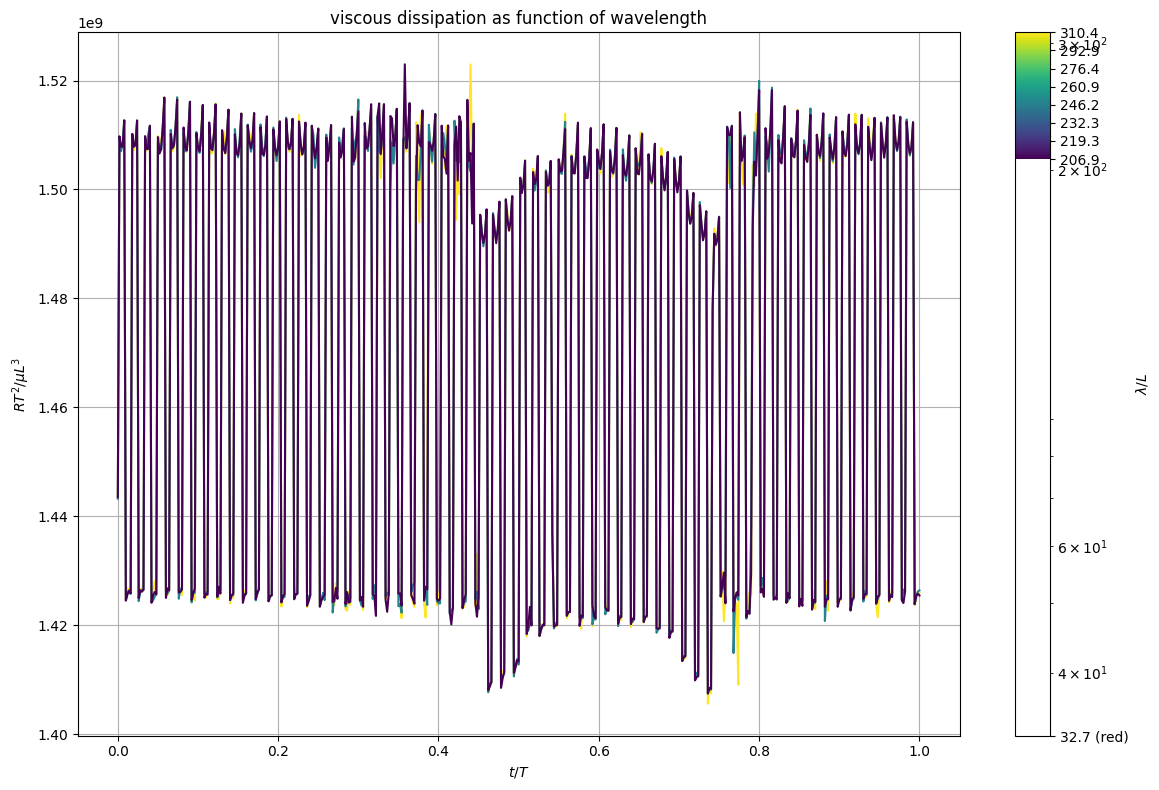

In [14]:
def plot_energy_dissipation(energy_dissipation, time):
    plt.figure(figsize=(12, 8))
    
    # Get the list of wavenumbers and sort them
    wavenumbers = sorted(energy_dissipation.keys())
    wavelengths = [np.pi * 395.2 / N for N in wavenumbers]
    
    # Normalize the wavenumbers to [0, 1] for colormap
    norm = LogNorm(vmin=min(wavelengths), vmax=max(wavelengths))
    cmap = plt.get_cmap('viridis')
    
    for N in wavenumbers:
        # Calculate the wavelength
        wavelength = np.pi * 395.2 / N
        
        # Get the color for the current wavenumber
        color = 'red' if N == 38 else cmap(norm(wavelength))
        
        # Plot dissipation against time
        plt.plot(time, energy_dissipation[N], color=color)
    
    plt.xlabel(r'$t/T$')
    plt.ylabel(r'$RT^2/\mu L^3$')
    plt.title('viscous dissipation as function of wavelength')
    plt.grid(True)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label(r'$\lambda/L$')
    
    # Create logarithmically spaced ticks
    log_min = np.log(min(wavelengths))
    log_max = np.log(max(wavelengths))
    log_ticks = np.linspace(log_min, log_max, 8)
    new_ticks = np.exp(log_ticks)
    
    # Add k=38 wavelength
    wavelength_38 = np.pi * 395.2 / 38
    new_ticks = np.sort(np.append(new_ticks, wavelength_38))
    
    # Create labels
    labels = [f'{t:.1f}' + (
        ' (red)' if np.isclose(t, wavelength_38, rtol=1e-10) else ''
    ) for t in new_ticks]
    
    # Set ticks and labels
    cbar.set_ticks(new_ticks)
    cbar.set_ticklabels(labels)
    
    plt.tight_layout()
    plt.show()

# Plot the energy dissipation vs time
plot_energy_dissipation(energy_dissipation, time)

Lowering the wavelength seems to make the energy dissipation higher up to a point. It is noteworthy that the actual system seems to have less variance, although this view of dissipation is inherently difficult to read.

Let's take a look at wavelength versus average dissipation (which is the same picture as total energy).

/tmp/ipykernel_1875233/13571591.py:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


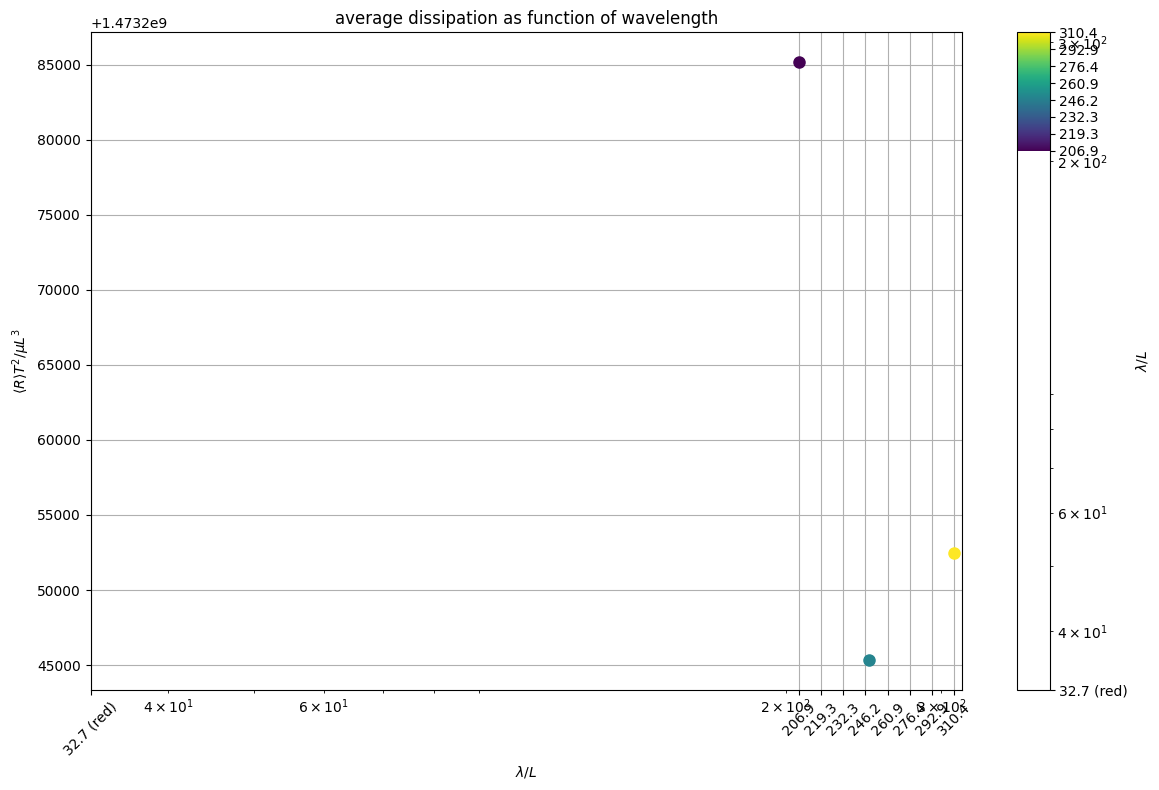

In [15]:
def plot_energy_vs_wavelength(data_dict, energy_dissipation):
    avg_energies = []
    wavelengths = []
    wavenumbers = sorted(data_dict.keys())
    
    for k, data in data_dict.items():
        if k in energy_dissipation:
            # Calculate average energy dissipation
            avg_energy = np.mean(energy_dissipation[k])
            
            avg_energies.append(avg_energy)
            wavelength = np.pi * 395.2 / k
            wavelengths.append(wavelength)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Create color mapping
    norm = LogNorm(vmin=min(wavelengths), vmax=max(wavelengths))
    cmap = plt.get_cmap('viridis')
    
    # Plot average energies
    for wavelength, avg_energy in zip(wavelengths, avg_energies):
        if np.isclose(wavelength, np.pi * 395.2 / 38, rtol=1e-10):
            plt.plot(wavelength, avg_energy, 'ro', markersize=10)
        else:
            color = cmap(norm(wavelength))
            plt.plot(wavelength, avg_energy, 'o', color=color, markersize=8)
    
    # Set log scale for x-axis
    plt.xscale('log')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label(r'$\lambda/L$')
    
    # Create logarithmically spaced ticks
    log_min = np.log(min(wavelengths))
    log_max = np.log(max(wavelengths))
    log_ticks = np.linspace(log_min, log_max, 8)
    new_ticks = np.exp(log_ticks)
    
    # Add k=38 wavelength
    wavelength_38 = np.pi * 395.2 / 38
    new_ticks = np.sort(np.append(new_ticks, wavelength_38))
    
    # Create labels
    labels = [f'{t:.1f}' + (
        ' (red)' if np.isclose(t, wavelength_38, rtol=1e-10) else ''
    ) for t in new_ticks]
    
    # Set ticks and labels
    plt.xticks(new_ticks, labels, rotation=45)
    cbar.set_ticks(new_ticks)
    cbar.set_ticklabels(labels)
    
    # Set labels and title
    plt.xlabel(r'$\lambda/L$')
    plt.ylabel(r'$\langle R\rangle T^2/\mu L^3$')
    plt.title('average dissipation as function of wavelength')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot energy vs wavelength
plot_energy_vs_wavelength(data_dict_clean, energy_dissipation)


There doesn't seem to be an obvious importance of the real system in this view: the smaller the wavelength, the more energy expenditure in general.

Finally we study the hydrodynamic efficiency as a function of wavelength.

/tmp/ipykernel_1875233/2069142195.py:59: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


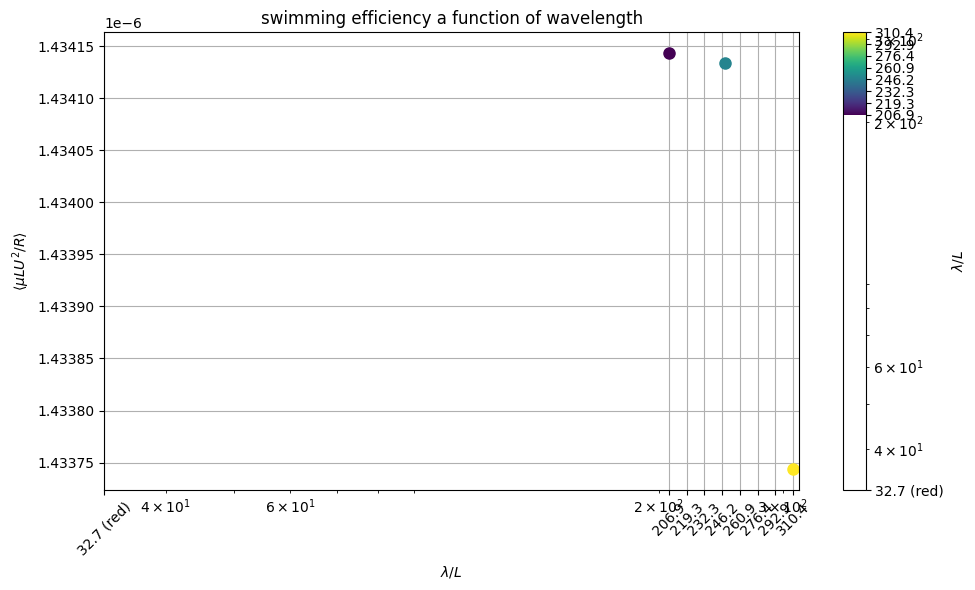

In [16]:
def compute_speed2_dissipation_ratio(data_dict, energy_dissipation):
  speed2_dissipation_ratio = {}

  for N, data in data_dict.items():
    if data["body_vel"] is not None:
      # Calculate the norm of the linear velocity
      speed = np.linalg.norm(data["body_vel"]["linear"], axis=1)
      
      # Calculate the average speed over time
      avg_speed = np.mean(speed)
      
      # Calculate the total energy dissipation over time
      total_dissipation = np.sum(energy_dissipation[N])
      
      # Compute the ratio
      ratio = avg_speed / total_dissipation
      speed2_dissipation_ratio[N] = np.mean(speed**2/energy_dissipation[N])

  return speed2_dissipation_ratio

# Compute the speed to dissipation ratio
speed2_dissipation_ratio = compute_speed2_dissipation_ratio(
   data_dict_clean, energy_dissipation
)

# Plot the ratio against wavelength
def plot_speed_dissipation_ratio(speed_dissipation_ratio):
    wavelengths = []
    ratios = []
    wavenumbers = sorted(speed_dissipation_ratio.keys())
    
    for N in wavenumbers:
        ratio = speed_dissipation_ratio[N]
        wavelength = np.pi * 395.2 / N
        wavelengths.append(wavelength)
        ratios.append(ratio)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Create color mapping
    norm = LogNorm(vmin=min(wavelengths), vmax=max(wavelengths))
    cmap = plt.get_cmap('viridis')
    
    # Plot points with colors based on wavelength
    for wavelength, ratio in zip(wavelengths, ratios):
        if np.isclose(wavelength, np.pi * 395.2 / 38, rtol=1e-10):
            plt.plot(wavelength, ratio, 'ro', markersize=10)  # Red dot for k=38
        else:
            color = cmap(norm(wavelength))
            plt.plot(wavelength, ratio, 'o', color=color, markersize=8)
    
    # Set log scale for x-axis
    plt.xscale('log')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label(r'$\lambda/L$')
    
    # Create logarithmically spaced ticks
    log_min = np.log(min(wavelengths))
    log_max = np.log(max(wavelengths))
    log_ticks = np.linspace(log_min, log_max, 8)
    new_ticks = np.exp(log_ticks)
    
    # Add k=38 wavelength
    wavelength_38 = np.pi * 395.2 / 38
    new_ticks = np.sort(np.append(new_ticks, wavelength_38))
    
    # Create labels
    labels = [f'{t:.1f}' + (
       ' (red)' if np.isclose(t, wavelength_38, rtol=1e-10) else ''
    ) for t in new_ticks]
    
    # Set ticks and labels for both plot and colorbar
    plt.xticks(new_ticks, labels, rotation=45)
    cbar.set_ticks(new_ticks)
    cbar.set_ticklabels(labels)
    
    plt.xlabel(r'$\lambda/L$')
    plt.ylabel(r'$ \langle \mu L U^2 / R \rangle $')
    plt.title('swimming efficiency a function of wavelength')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the ratio
plot_speed_dissipation_ratio(speed2_dissipation_ratio)


With the correct measure of efficiency, the real system is closer to the maximum than before. Given the approximation of one one ring of cilia, there might be a case for the idea that the wavelength of the real system maximises efficiency and top speed.